In [1]:
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
from functools import reduce
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplitModel
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark_session = SparkSession.builder \
    .master("local[1]") \
    .appName("Airlines analysis") \
    .getOrCreate()

23/04/04 21:40:37 WARN Utils: Your hostname, kuro2k-XPS-15-9560 resolves to a loopback address: 127.0.1.1; using 192.168.1.205 instead (on interface wlp2s0)
23/04/04 21:40:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 21:40:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Preparing data

In [3]:
airlines_df = spark_session.read.option("header", True).csv("Airlines.csv", inferSchema=True)
airlines_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Flight: integer (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Length: integer (nullable = true)
 |-- Delay: integer (nullable = true)



In [4]:
airlines_df.show(5)

+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  1|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|
|  2|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|
|  3|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|
|  4|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|
|  5|     AS|   108|        ANC|      SEA|        3|  30|   202|    0|
+---+-------+------+-----------+---------+---------+----+------+-----+
only showing top 5 rows



# Count null value in dataset

In [5]:
df2 = airlines_df.select([fn.count(fn.when(fn.col(c).contains('None') | \
                                           fn.col(c).contains('NULL') | \
                                           (fn.col(c) == '') | \
                                           fn.col(c).isNull() | \
                                           fn.isnan(c), c
                                           )).alias(c)
                          for c in airlines_df.columns])
df2.show(5)

+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  0|      0|     0|          0|        0|        0|   0|     0|    0|
+---+-------+------+-----------+---------+---------+----+------+-----+



In [6]:
airlines_df2 = airlines_df.drop("id")

# Visualize some features of data

<Axes: ylabel='Frequency'>

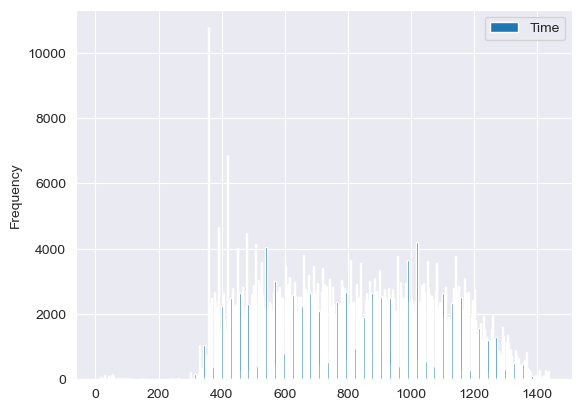

In [7]:
airlines_df2.select("Time").toPandas().plot.hist(bins=400)

<Axes: ylabel='Frequency'>

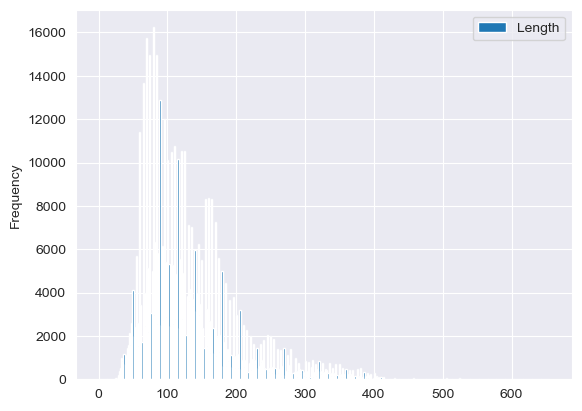

In [8]:
airlines_df2.select("Length").toPandas().plot.hist(bins=400)

In [9]:
airlines_df3 = airlines_df2.withColumn("Length_by_hours", fn.col("Length") / 60) \
                           .withColumn("Time_by_hours", fn.col("Time") / 60) \
                           .drop("Length", "Time")

<Axes: ylabel='Frequency'>

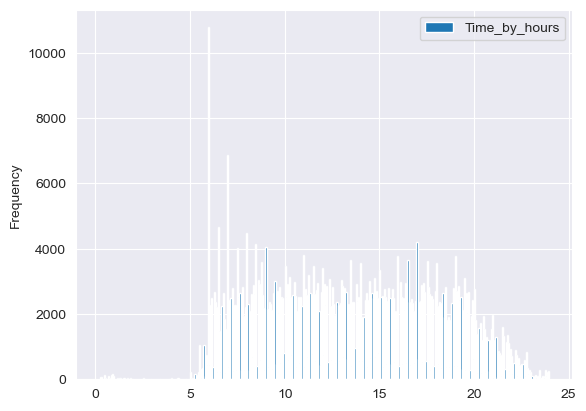

In [10]:
airlines_df3.select("Time_by_hours").toPandas().plot.hist(bins=400)

<Axes: ylabel='Frequency'>

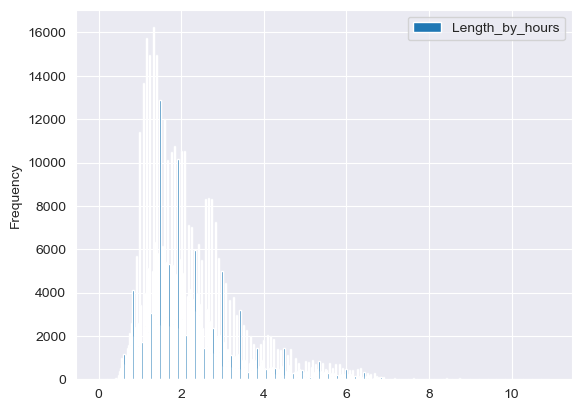

In [11]:
airlines_df3.select("Length_by_hours").toPandas().plot.hist(bins=400)

# Transform data

In [12]:
# 0 ---> Morning | 1 ---> Afternoon | 2 ----> Evening | 3 ----> Night
# 0 ---> not holiday | 1 ---> holiday
airlines_df4 = airlines_df3.withColumn("Departure_period",
                                        fn.when((5.2 <= fn.col("Time_by_hours")) & (fn.col("Time_by_hours") < 12), 0)
                                            .when((12 <= fn.col("Time_by_hours")) & (fn.col("Time_by_hours") < 17), 1)
                                            .when((17 <= fn.col("Time_by_hours")) & (fn.col("Time_by_hours") < 23), 2)
                                            .otherwise(3)
                                       ) \
                            .withColumn("Holiday", fn.when((fn.col("DayOfWeek") == 6) | (fn.col("DayOfWeek") == 7), 1)
                                                    .otherwise(0)
                                        ) \
                            .drop("Time_by_hours")
airlines_df4.groupBy("Departure_period").count().show()
airlines_df4.groupBy("Holiday").count().show()
airlines_df4.show()

+----------------+------+
|Departure_period| count|
+----------------+------+
|               1|170239|
|               3|  3802|
|               2|142360|
|               0|222982|
+----------------+------+



+-------+------+
|Holiday| count|
+-------+------+
|      1|128835|
|      0|410548|
+-------+------+

+-------+------+-----------+---------+---------+-----+------------------+----------------+-------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Delay|   Length_by_hours|Departure_period|Holiday|
+-------+------+-----------+---------+---------+-----+------------------+----------------+-------+
|     CO|   269|        SFO|      IAH|        3|    1|3.4166666666666665|               3|      0|
|     US|  1558|        PHX|      CLT|        3|    1|               3.7|               3|      0|
|     AA|  2400|        LAX|      DFW|        3|    1|              2.75|               3|      0|
|     AA|  2466|        SFO|      DFW|        3|    1|              3.25|               3|      0|
|     AS|   108|        ANC|      SEA|        3|    0|3.3666666666666667|               3|      0|
|     CO|  1094|        LAX|      IAH|        3|    1|3.0166666666666666|               3|      0|
|     

# Count Value

In [13]:
df4 = [airlines_df4.groupBy(c).count().orderBy(fn.col("count").asc()).select(c, fn.col("count").alias(f"{c}_count"))
                          for c in airlines_df4.columns if c != "Length_by_hours"]
for x in df4:
    x.show()
    print(x.toPandas().describe())
print(airlines_df4.select("Length_by_hours").toPandas().describe())

+-------+-------------+
|Airline|Airline_count|
+-------+-------------+
|     HA|         5578|
|     F9|         6456|
|     AS|        11471|
|     OH|        12630|
|     YV|        13725|
|     B6|        18112|
|     9E|        20686|
|     FL|        20827|
|     CO|        21118|
|     UA|        27619|
|     EV|        27983|
|     XE|        31126|
|     US|        34500|
|     MQ|        36605|
|     AA|        45656|
|     OO|        50254|
|     DL|        60940|
|     WN|        94097|
+-------+-------------+



       Airline_count
count      18.000000
mean    29965.722222
std     22026.299042
min      5578.000000
25%     14821.750000
50%     24368.500000
75%     36078.750000
max     94097.000000


+------+------------+
|Flight|Flight_count|
+------+------------+
|  3349|           1|
|  4544|           1|
|  5131|           1|
|  3573|           1|
|  5606|           1|
|  3518|           1|
|  3385|           1|
|  6969|           1|
|  4385|           1|
|  3455|           1|
|  4710|           1|
|  3292|           1|
|  7814|           1|
|  3184|           1|
|  5559|           1|
|  3413|           1|
|  3387|           2|
|  4610|           2|
|  3195|           2|
|  3207|           2|
+------+------------+
only showing top 20 rows



            Flight  Flight_count
count  6585.000000   6585.000000
mean   3475.050266     81.910858
std    2130.114757     60.450921
min       1.000000      1.000000
25%    1651.000000     38.000000
50%    3322.000000     62.000000
75%    5142.000000    111.000000
max    7814.000000    420.000000


+-----------+-----------------+
|AirportFrom|AirportFrom_count|
+-----------+-----------------+
|        ABR|                2|
|        ADK|                9|
|        GUM|               10|
|        SJT|               15|
|        MMH|               16|
|        FLO|               18|
|        UTM|               18|
|        PIE|               23|
|        BLI|               26|
|        TEX|               27|
|        TOL|               27|
|        DBQ|               27|
|        GGG|               31|
|        CYS|               31|
|        CLL|               31|
|        BGR|               32|
|        PLN|               32|
|        STX|               46|
|        SPS|               46|
|        CDC|               55|
+-----------+-----------------+
only showing top 20 rows



       AirportFrom_count
count         293.000000
mean         1840.897611
std          4015.279914
min             2.000000
25%           120.000000
50%           361.000000
75%          1244.000000
max         34449.000000


+---------+---------------+
|AirportTo|AirportTo_count|
+---------+---------------+
|      ABR|              2|
|      ADK|              9|
|      GUM|             10|
|      SJT|             15|
|      MMH|             16|
|      FLO|             18|
|      UTM|             18|
|      PIE|             23|
|      BLI|             26|
|      TEX|             27|
|      TOL|             27|
|      DBQ|             27|
|      GGG|             31|
|      CYS|             31|
|      CLL|             31|
|      BGR|             32|
|      PLN|             32|
|      STX|             45|
|      SPS|             46|
|      CDC|             54|
+---------+---------------+
only showing top 20 rows



       AirportTo_count
count       293.000000
mean       1840.897611
std        4016.329857
min           2.000000
25%         120.000000
50%         361.000000
75%        1244.000000
max       34440.000000


+---------+---------------+
|DayOfWeek|DayOfWeek_count|
+---------+---------------+
|        6|          58956|
|        7|          69879|
|        2|          71340|
|        1|          72769|
|        5|          85248|
|        3|          89746|
|        4|          91445|
+---------+---------------+



       DayOfWeek  DayOfWeek_count
count   7.000000         7.000000
mean    4.000000     77054.714286
std     2.160247     12009.431207
min     1.000000     58956.000000
25%     2.500000     70609.500000
50%     4.000000     72769.000000
75%     5.500000     87497.000000
max     7.000000     91445.000000


+-----+-----------+
|Delay|Delay_count|
+-----+-----------+
|    1|     240264|
|    0|     299119|
+-----+-----------+



          Delay    Delay_count
count  2.000000       2.000000
mean   0.500000  269691.500000
std    0.707107   41616.769607
min    0.000000  240264.000000
25%    0.250000  254977.750000
50%    0.500000  269691.500000
75%    0.750000  284405.250000
max    1.000000  299119.000000


+----------------+----------------------+
|Departure_period|Departure_period_count|
+----------------+----------------------+
|               3|                  3802|
|               2|                142360|
|               1|                170239|
|               0|                222982|
+----------------+----------------------+



       Departure_period  Departure_period_count
count          4.000000                4.000000
mean           1.500000           134845.750000
std            1.290994            93540.738143
min            0.000000             3802.000000
25%            0.750000           107720.500000
50%            1.500000           156299.500000
75%            2.250000           183424.750000
max            3.000000           222982.000000


+-------+-------------+
|Holiday|Holiday_count|
+-------+-------------+
|      1|       128835|
|      0|       410548|
+-------+-------------+



        Holiday  Holiday_count
count  2.000000       2.000000
mean   0.500000  269691.500000
std    0.707107  199201.172648
min    0.000000  128835.000000
25%    0.250000  199263.250000
50%    0.500000  269691.500000
75%    0.750000  340119.750000
max    1.000000  410548.000000


       Length_by_hours
count    539383.000000
mean          2.203367
std           1.168617
min           0.000000
25%           1.350000
50%           1.916667
75%           2.700000
max          10.916667


# Remove outliner

In [14]:
airlines_df5 = airlines_df4.filter(fn.col("Length_by_hours") >= 0.5).filter(fn.col("Length_by_hours") < 5)
for x in df4:
    if x.columns[0] == "Flight":
        x1 = x.filter(fn.col(x.columns[1]) > 15)
        airlines_df5 = airlines_df5.filter(fn.col("Flight").isin(list(x1.toPandas()["Flight"])))
    elif x.columns[0] == "AirportTo":
        x1 = x.filter(fn.col(x.columns[1]) > 30)
        airlines_df5 = airlines_df5.filter(fn.col("AirportTo").isin(list(x1.toPandas()["AirportTo"])))
    elif x.columns[0] == "AirportFrom":
        x1 = x.filter(fn.col(x.columns[1]) > 30)
        airlines_df5 = airlines_df5.filter(fn.col("AirportFrom").isin(list(x1.toPandas()["AirportFrom"])))
airlines_df5.show()

+-------+------+-----------+---------+---------+-----+------------------+----------------+-------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Delay|   Length_by_hours|Departure_period|Holiday|
+-------+------+-----------+---------+---------+-----+------------------+----------------+-------+
|     CO|   269|        SFO|      IAH|        3|    1|3.4166666666666665|               3|      0|
|     US|  1558|        PHX|      CLT|        3|    1|               3.7|               3|      0|
|     AA|  2400|        LAX|      DFW|        3|    1|              2.75|               3|      0|
|     AA|  2466|        SFO|      DFW|        3|    1|              3.25|               3|      0|
|     AS|   108|        ANC|      SEA|        3|    0|3.3666666666666667|               3|      0|
|     CO|  1094|        LAX|      IAH|        3|    1|3.0166666666666666|               3|      0|
|     DL|  1768|        LAX|      MSP|        3|    0|3.6666666666666665|               3|      0|
|     DL| 

In [15]:
df5 = [airlines_df5.groupBy(c).count().orderBy(fn.col("count").asc()).select(c, fn.col("count").alias(f"{c}_count"))
                          for c in airlines_df5.columns]
for x in df5:
    x.show()
    print(x.toPandas().describe())
    # x.toPandas().plot.bar(x=x.columns[0], y=x.columns[1])

+-------+-------------+
|Airline|Airline_count|
+-------+-------------+
|     HA|         4575|
|     F9|         6407|
|     AS|         9931|
|     OH|        12587|
|     YV|        13477|
|     B6|        16175|
|     CO|        19034|
|     9E|        20360|
|     FL|        20587|
|     UA|        23402|
|     EV|        26765|
|     XE|        31099|
|     US|        32083|
|     MQ|        36254|
|     AA|        42609|
|     OO|        49337|
|     DL|        57041|
|     WN|        92335|
+-------+-------------+



       Airline_count
count      18.000000
mean    28558.777778
std     21537.940924
min      4575.000000
25%     14151.500000
50%     21994.500000
75%     35211.250000
max     92335.000000


+------+------------+
|Flight|Flight_count|
+------+------------+
|   935|           2|
|  4961|           2|
|  2329|           4|
|  1549|           9|
|  2365|          11|
|  1797|          11|
|  6967|          13|
|  1535|          14|
|  7218|          16|
|  4958|          16|
|  4538|          16|
|  2255|          16|
|  4700|          16|
|  6904|          16|
|  5087|          16|
|  4837|          16|
|  1542|          16|
|  6720|          16|
|  3502|          16|
|  3155|          16|
+------+------------+
only showing top 20 rows



            Flight  Flight_count
count  6268.000000   6268.000000
mean   3398.966656     82.013082
std    2126.584335     54.899631
min       1.000000      2.000000
25%    1576.750000     42.000000
50%    3151.500000     63.000000
75%    5086.250000    109.000000
max    7812.000000    339.000000


+-----------+-----------------+
|AirportFrom|AirportFrom_count|
+-----------+-----------------+
|        WRG|               29|
|        GGG|               31|
|        CLL|               31|
|        CYS|               31|
|        PLN|               32|
|        BGR|               32|
|        PSG|               39|
|        STX|               46|
|        SPS|               46|
|        CDC|               54|
|        ADQ|               56|
|        SCC|               56|
|        CDV|               57|
|        HTS|               57|
|        LWS|               57|
|        YAK|               57|
|        MEI|               58|
|        LYH|               59|
|        ACT|               60|
|        TYR|               60|
+-----------+-----------------+
only showing top 20 rows



       AirportFrom_count
count         281.000000
mean         1829.387900
std          3908.894107
min            29.000000
25%           135.000000
50%           387.000000
75%          1390.000000
max         32935.000000


+---------+---------------+
|AirportTo|AirportTo_count|
+---------+---------------+
|      PSG|             29|
|      CLL|             31|
|      IPL|             31|
|      GGG|             31|
|      CYS|             31|
|      BGR|             32|
|      PLN|             32|
|      WRG|             39|
|      ACT|             44|
|      STX|             45|
|      SPS|             46|
|      CDC|             54|
|      SCC|             56|
|      ADQ|             56|
|      CDV|             57|
|      HTS|             57|
|      LWS|             57|
|      YAK|             57|
|      MEI|             58|
|      LYH|             59|
+---------+---------------+
only showing top 20 rows



       AirportTo_count
count       281.000000
mean       1829.387900
std        3909.854863
min          29.000000
25%         135.000000
50%         382.000000
75%        1405.000000
max       34032.000000


+---------+---------------+
|DayOfWeek|DayOfWeek_count|
+---------+---------------+
|        6|          55870|
|        7|          66402|
|        2|          68168|
|        1|          69461|
|        5|          81175|
|        3|          85739|
|        4|          87243|
+---------+---------------+



       DayOfWeek  DayOfWeek_count
count   7.000000         7.000000
mean    4.000000     73436.857143
std     2.160247     11572.115442
min     1.000000     55870.000000
25%     2.500000     67285.000000
50%     4.000000     69461.000000
75%     5.500000     83457.000000
max     7.000000     87243.000000


+-----+-----------+
|Delay|Delay_count|
+-----+-----------+
|    1|     228701|
|    0|     285357|
+-----+-----------+



          Delay    Delay_count
count  2.000000       2.000000
mean   0.500000  257029.000000
std    0.707107   40061.841795
min    0.000000  228701.000000
25%    0.250000  242865.000000
50%    0.500000  257029.000000
75%    0.750000  271193.000000
max    1.000000  285357.000000


+------------------+---------------------+
|   Length_by_hours|Length_by_hours_count|
+------------------+---------------------+
| 4.716666666666667|                   66|
|0.5166666666666667|                   66|
|              4.95|                   87|
| 4.933333333333334|                  108|
| 4.433333333333334|                  112|
|              4.55|                  121|
| 4.816666666666666|                  124|
| 4.983333333333333|                  137|
|              4.85|                  160|
| 4.783333333333333|                  163|
| 4.766666666666667|                  165|
|              3.85|                  180|
| 4.266666666666667|                  185|
| 4.516666666666667|                  189|
|               4.7|                  206|
| 4.383333333333334|                  209|
| 4.866666666666666|                  223|
| 4.183333333333334|                  224|
|3.8833333333333333|                  230|
|               4.9|                  230|
+----------

       Length_by_hours  Length_by_hours_count
count       270.000000             270.000000
mean          2.741667            1903.918519
std           1.301442            2353.463720
min           0.500000              66.000000
25%           1.620833             406.500000
50%           2.741667            1197.000000
75%           3.862500            2414.000000
max           4.983333           13173.000000


+----------------+----------------------+
|Departure_period|Departure_period_count|
+----------------+----------------------+
|               3|                  3176|
|               2|                134972|
|               1|                163243|
|               0|                212667|
+----------------+----------------------+



       Departure_period  Departure_period_count
count          4.000000                4.000000
mean           1.500000           128514.500000
std            1.290994            89515.642687
min            0.000000             3176.000000
25%            0.750000           102023.000000
50%            1.500000           149107.500000
75%            2.250000           175599.000000
max            3.000000           212667.000000


+-------+-------------+
|Holiday|Holiday_count|
+-------+-------------+
|      1|       122272|
|      0|       391786|
+-------+-------------+



        Holiday  Holiday_count
count  2.000000       2.000000
mean   0.500000  257029.000000
std    0.707107  190575.177025
min    0.000000  122272.000000
25%    0.250000  189650.500000
50%    0.500000  257029.000000
75%    0.750000  324407.500000
max    1.000000  391786.000000


In [16]:
indexer = StringIndexer(inputCols=["Airline", "AirportFrom", "AirportTo"], outputCols=["AirlineIndexer", "AirportFromIndexer", "AirportToIndexer"])
airlines_df6 = indexer.fit(airlines_df5).transform(airlines_df5)
airlines_df6 = airlines_df6.drop("Airline", "AirportFrom", "AirportTo")
airlines_df6.show()

+------+---------+-----+------------------+----------------+-------+--------------+------------------+----------------+
|Flight|DayOfWeek|Delay|   Length_by_hours|Departure_period|Holiday|AirlineIndexer|AirportFromIndexer|AirportToIndexer|
+------+---------+-----+------------------+----------------+-------+--------------+------------------+----------------+
|   269|        3|    1|3.4166666666666665|               3|      0|          11.0|              13.0|             4.0|
|  1558|        3|    1|               3.7|               3|      0|           5.0|               5.0|             8.0|
|  2400|        3|    1|              2.75|               3|      0|           3.0|               6.0|             2.0|
|  2466|        3|    1|              3.25|               3|      0|           3.0|              13.0|             2.0|
|   108|        3|    0|3.3666666666666667|               3|      0|          15.0|              76.0|            22.0|
|  1094|        3|    1|3.01666666666666

# Correlation among features

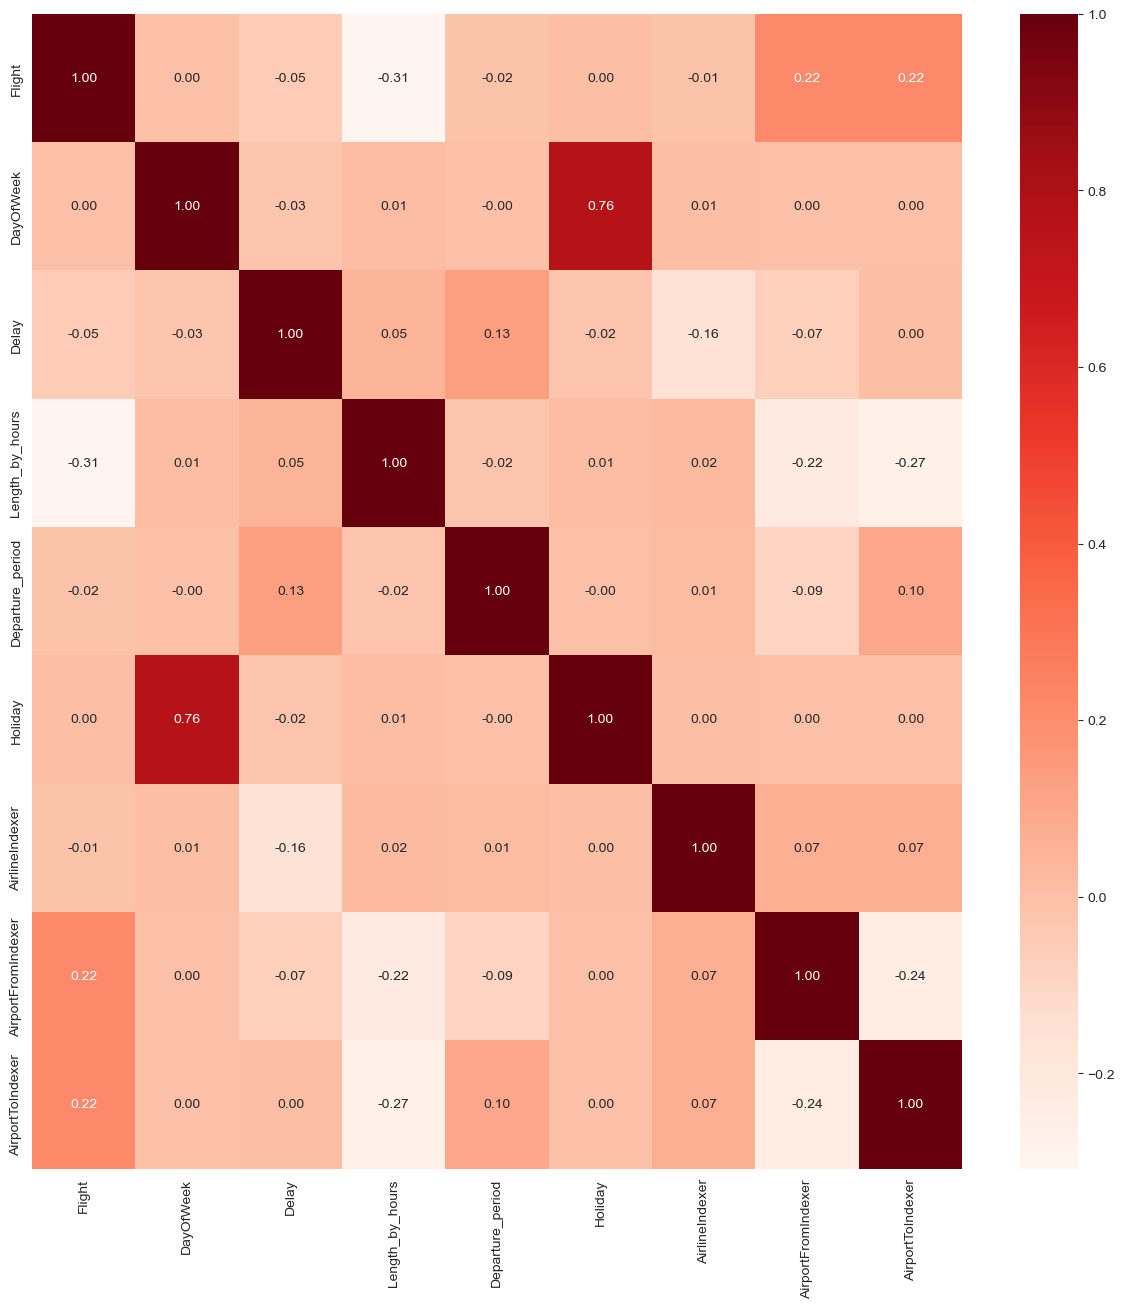

In [17]:
plt.figure(figsize=(15,15))
cor = airlines_df6.toPandas().corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

# Transform data for training model

In [18]:
airlines_vector_assembler = VectorAssembler(inputCols=[x for x in airlines_df6.columns if x != "Delay"], outputCol="features")
X = airlines_vector_assembler.transform(airlines_df6).select("features", fn.col("Delay"))
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=100).fit(X)
(training_data, test_data) = X.randomSplit([0.8, 0.2])

# LogisticRegression

In [19]:
lr = LogisticRegression(featuresCol="features", labelCol="Delay", regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[featureIndexer, lr])
model = pipeline.fit(training_data)

In [20]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy on test data = %g" % accuracy)

Accuracy on test data = 0.554345


# Auto Tuning Logistic regression

In [21]:
lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
grid = ParamGridBuilder().addGrid(lr.regParam, np.arange(0, 1, .05)).addGrid(lr.elasticNetParam, np.arange(0, 1, 0.2)).build()
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=42)
tvsModel = tvs.fit(dataset=training_data.select("features", fn.col("Delay").alias("label")))

In [22]:
accuracy = evaluator.evaluate(tvsModel.transform(test_data.select("features", fn.col("Delay").alias("label"))))
print(tvsModel.validationMetrics)
print("Accuracy on test data = %g" % accuracy)

[0.6082655208868801, 0.6082655208868801, 0.6082655208868801, 0.6082655208868801, 0.6082655208868801, 0.6081879285762781, 0.6077320737514912, 0.6083334141586568, 0.6118638642910488, 0.5853369931039833, 0.6072665198878792, 0.6034160014742539, 0.5864329844912369, 0.5538927092325151, 0.5538927092325151, 0.6060832371511983, 0.5857346536958188, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.6026982726011852, 0.5537278255724858, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5999049494195126, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5963454021706449, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5932805059018651, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5894687836435409, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5862971979476834, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151, 0.5538927092325151,

# Decision Tree

In [23]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Delay", maxBins=300)
pipeline = Pipeline(stages=[featureIndexer, dt])
model = pipeline.fit(training_data)

In [24]:
# Make predictions.
predictions = model.transform(test_data)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Delay", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

Accuracy = 0.635479


# Gradient-boosted tree classifier

In [25]:
gbt = GBTClassifier(labelCol="Delay", featuresCol="indexedFeatures", maxBins=300)
pipeline = Pipeline(stages=[featureIndexer, gbt])

model = pipeline.fit(training_data)

23/04/04 22:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
23/04/04 22:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB


In [26]:
# Make predictions.
predictions = model.transform(test_data)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Delay", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

23/04/04 22:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1033.5 KiB


Accuracy = 0.656937


# Naive Bayes

In [27]:
nb = NaiveBayes(labelCol="Delay" ,smoothing=1.0, modelType="multinomial")
pipeline = Pipeline(stages=[featureIndexer, nb])

model = pipeline.fit(training_data)

In [28]:
# select example rows to display.
predictions = model.transform(test_data)
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.5407819263804879
